In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
path = "./input/"

df = pd.read_csv(path + "train.csv")
df_test = pd.read_csv(path + "test.csv")

data = pd.concat([df, df_test], sort=False)

print(df.shape)
print(df_test.shape)

(7134, 29)
(1794, 28)


In [3]:
# Create base line model
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error as MAE

str_list =["Id", "groupId", "matchId", "matchType"]

X, y = df.drop(str_list, axis=1).iloc[:, :-1], df.iloc[:, -1]
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

In [4]:
# XGBoost baseline
import xgboost as xgb

xgr = xgb.XGBRegressor()
xgr.fit(X_train, y_train)
preds_xgr = xgr.predict(X_valid)

score_xgb = MAE(y_valid, preds_xgr)
print("Score with xgboost regressor:", score_xgb)

[15:05:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Score with xgboost regressor: 0.0679120909551406


In [10]:
train_DMatrix = xgb.DMatrix(data=X_train, label=y_train)
valid_DMatrix = xgb.DMatrix(data=X_valid, label=y_valid)
pubg_DMatrix = xgb.DMatrix(X, y)

params = {"objective":"reg:linear", "max_depth":4}

xgr_cv = xgb.XGBRegressor()

cv_results = xgb.cv(dtrain=train_DMatrix, params=params, nfold=5, num_boost_round=10, metrics="mae", as_pandas=True, seed=42)

# preds = xgb.predict(X_valid)

print(cv_results)
print("*****************************")
print((cv_results["test-mae-mean"]))

[15:05:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:05:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:05:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:05:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:05:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
   train-mae-mean  train-mae-std  test-mae-mean  test-mae-std
0        0.192878       0.001234       0.193364      0.005698
1        0.150147       0.001086       0.151258      0.005023
2        0.121571       0.000741       0.123136      0.004249
3        0.102160       0.000760       0.104454      0.003944
4        0.089528       0.000848       0.092363      0.003325
5        0.081437       0.000615       0.084732 

In [11]:
params = {"objective":"reg:linear", "max_depth":5}
num_rounds = [n for n in range(5, 100, 2)]
final_mae_per_round = []

for curr_num_rounds in num_rounds:

    # Perform cross-validation: cv_results
    cv_results = xgb.cv(dtrain=pubg_DMatrix, params=params, nfold=5, num_boost_round=curr_num_rounds, metrics="mae", as_pandas=True, early_stopping_rounds=5,seed=123)

    final_mae_per_round.append(cv_results["test-mae-mean"].tail().values[-1])

num_rounds_mae = list(zip(num_rounds, final_mae_per_round))
print(pd.DataFrame(num_rounds_mae, columns=["num_boosting_rounds", "mae"]))


rror.
[15:06:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:06:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:06:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:06:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:06:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:06:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:06:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:06:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:06:40] WARNING: src/objective/regression_obj.cu:152: reg:linea

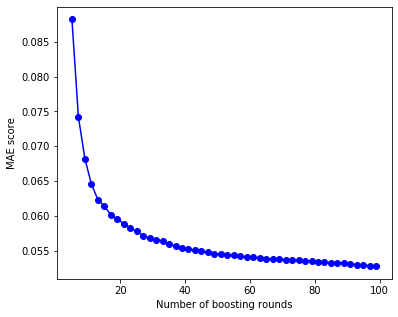

In [12]:
plt.figure(figsize=(6,5))
plt.plot(num_rounds, final_mae_per_round, "o-",color="blue")
plt.xlabel("Number of boosting rounds")
plt.ylabel("MAE score")
plt.show()

In [13]:
df_test.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints
0,c9ce5e5749758a,d1d34623858d02,6533442a513d6f,0,0,100.0,1,1,0,38,...,1431,0,0.0,0,0.0,0,0,168.4,1,0
1,262418e6a1fd89,f0290ae9582198,976f4ae3c91669,0,0,0.0,0,0,0,76,...,-1,0,0.0,0,0.0,0,0,280.7,3,1639
2,1fdaad049557d9,d1d34623858d02,6533442a513d6f,1,0,57.0,1,0,0,71,...,1490,0,0.0,0,0.0,0,0,202.7,4,0
3,cb1761d22b957e,77234d376925f9,efd749a746587e,0,0,0.0,0,0,1,72,...,-1,0,0.0,0,0.0,0,0,123.1,2,1465
4,1b86424e60c2e8,19a7b7ce87c841,098d3f2da942e7,0,1,348.1,1,0,2,16,...,-1,0,0.0,0,0.0,0,0,1372.0,5,1398


[15:10:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


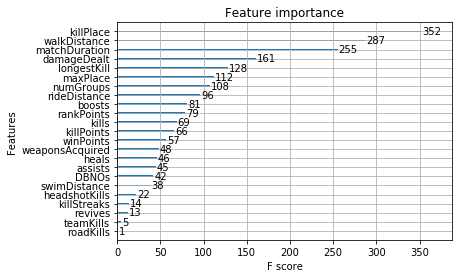

In [16]:
xg_reg = xgb.train(dtrain=pubg_DMatrix, params=params, num_boost_round=80)

X_test = df_test.drop(str_list, axis=1)
pubg_testDMatrix = xgb.DMatrix(X_test)
pubg_validDMatrix = xgb.DMatrix(X_valid)

predict_valid = xg_reg.predict(pubg_validDMatrix)
predict = xg_reg.predict(pubg_testDMatrix)

xgb.plot_importance(xg_reg)
plt.show()

In [17]:
print(MAE(predict_valid, y_valid))

0.035127778107151224


In [18]:
submission = pd.read_csv("submission.csv")
submission.head()

,winPlacePerc
0,0.160362
1,0.242487
2,0.215081
3,0.260389
4,0.552571


In [25]:
submission["winPlacePerc"] = predict
submission.to_csv("submission_xgb.csv", index=False)

In [26]:
submission_xgb = pd.read_csv("submission_xgb.csv")
submission_xgb.head()

,winPlacePerc
0,0.099776
1,0.215761
2,0.271668
3,0.270070
4,0.554272


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1aa92b70>]],
      dtype=object)

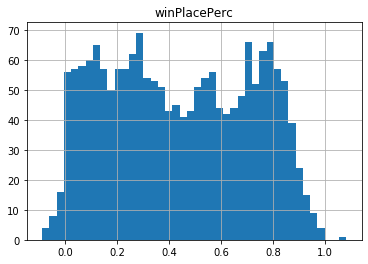

In [27]:
submission_xgb.hist(bins=int(np.sqrt(submission_xgb.shape[0])))